In [1]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy import optimize as opt
from sklearn import linear_model

#  Lorenz Attractor
Next we will attempt to implement our approach above for the Lorenz Attractor descroibed as,

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy -\beta z
\end{align*}

here we will consider the case that $\sigma = 10, \beta=\frac{8}{3}, \rho=28$, with intial condition $x(0)=0, y(0)=1, z(0)=1.05$.

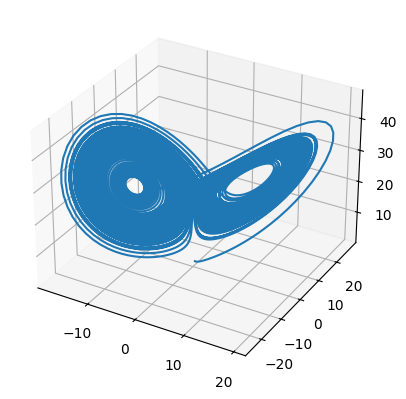

In [2]:
# set the parameters
sigma = 10
beta = 8/3
rho = 28

# define the lorenz attractor
def lorenz_attractor(xyz, t):
    x, y, z = xyz
    dx_dt = sigma*(y-x)
    dy_dt = x*(rho-z) - y
    dz_dt = x*y - beta*z
    return [dx_dt, dy_dt, dz_dt]

# set the initial conditions
initial_conditions = [0, 1, 1.05]

# plot the lorenz attractor
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2])
plt.show()


# Learning Coefficients of the Lorenz Attractor
Suppose that we don't know $\sigma, \beta, \rho$, and we want to learn these coefficients from the data. We can use the same approach as above, but now we will use the data from the Lorenz Attractor to learn the coefficients.

In [3]:
# generate the data
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)

# compute derivatives
dx = sigma*(xyz[:,1]-xyz[:,0])
dy = xyz[:,0]*(rho-xyz[:,2]) - xyz[:,1]
dz = xyz[:,0]*xyz[:,1] - beta*xyz[:,2]

Y = np.array([dx, dy, dz]).T

# solve using Least Squares Regression

# first create library of functions
ones = np.ones(len(t))
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]
x2 = x**2
y2 = y**2
z2 = z**2
xy = x*y
xz = x*z
yz = y*z

# create the library
A = np.array([ones, x, y, z, x2, y2, z2, xy, xz, yz]).T

# solve for the coefficients
clf = linear_model.Lasso(alpha=0.1)
clf.fit(A, Y)
coeff = clf.coef_

print(coeff)

[[ 0.00000000e+00 -9.32932836e+00  9.57834695e+00  0.00000000e+00
  -0.00000000e+00 -2.97748377e-04  1.31185558e-05  3.77986997e-04
  -1.87114613e-02  1.16615808e-02]
 [ 0.00000000e+00  2.73175980e+01 -5.70939517e-01 -0.00000000e+00
   1.40022748e-05  3.13924573e-04 -1.38321620e-05 -4.08778937e-04
  -9.80949854e-01 -1.18771990e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.40396241e+00
   3.51166828e-02  6.44179780e-03 -7.64805903e-03  9.68564339e-01
  -7.00352363e-06  5.14294092e-05]]


/home/moo/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+04, tolerance: 1.782e+03
  model = cd_fast.enet_coordinate_descent(
/home/moo/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e+04, tolerance: 4.179e+03
  model = cd_fast.enet_coordinate_descent(


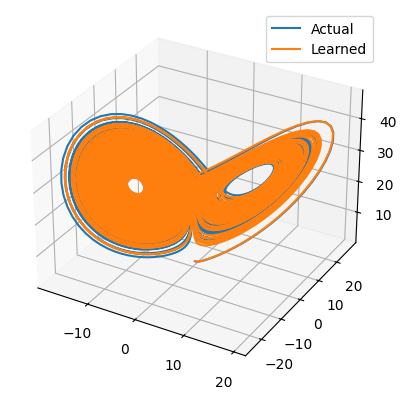

In [4]:
# plot Lorenz Attract using learned coefficients
def lorenz_attractor_learned(xyz, t):
    x, y, z = xyz
    dx_dt = coeff[0,0] + coeff[0,1]*x + coeff[0,2]*y + coeff[0,3]*z + coeff[0,4]*x**2 + coeff[0,5]*y**2 + coeff[0,6]*z**2 + coeff[0,7]*x*y + coeff[0,8]*x*z + coeff[0,9]*y*z
    dy_dt = coeff[1,0] + coeff[1,1]*x + coeff[1,2]*y + coeff[1,3]*z + coeff[1,4]*x**2 + coeff[1,5]*y**2 + coeff[1,6]*z**2 + coeff[1,7]*x*y + coeff[1,8]*x*z + coeff[1,9]*y*z
    dz_dt = coeff[2,0] + coeff[2,1]*x + coeff[2,2]*y + coeff[2,3]*z + coeff[2,4]*x**2 + coeff[2,5]*y**2 + coeff[2,6]*z**2 + coeff[2,7]*x*y + coeff[2,8]*x*z + coeff[2,9]*y*z
    return [dx_dt, dy_dt, dz_dt]

# set the initial conditions
initial_conditions = [0, 1, 1.05]

# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()


In [5]:
# Find Error between learned and actual Lorenz Attractor coefficients
error = np.linalg.norm(xyz-xyz_learned)
print(error)

1840.3722512582406


#  Lorenz Attractor (reminder)
Next we will attempt to implement our approach above for the Lorenz Attractor descroibed as,

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy -\beta z
\end{align*}

here we will consider the case that $\sigma = 10, \beta=\frac{8}{3}, \rho=28$, with intial condition $x(0)=0, y(0)=1, z(0)=1.05$.

In [6]:
coeff_exact = np.zeros(coeff.shape)
# order of terms goes..
# 1, x, y, z, x^2, y^2, z^2, xy, xz, yz

# dx/dt
coeff_exact[0, 1] = -sigma
coeff_exact[0, 2] = +sigma
# dy/dt
coeff_exact[1, 1] = rho
coeff_exact[1, 2] = -1
coeff_exact[1, 8] = -1
# dz/dt
coeff_exact[2, 7] = 1
coeff_exact[2, 3] = -beta

[Text(0.5, 1.0, 'Exact coefficient matrix'),
 [Text(0, 0, 'dx/dt'), Text(0, 1, 'dy/dt'), Text(0, 2, 'dz/dt')]]

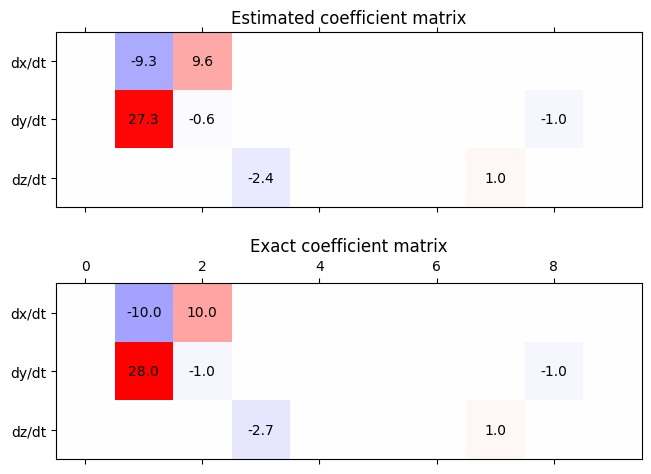

In [7]:
fig,ax = plt.subplots(2,1, sharex=True, sharey=True, constrained_layout=True)

ax[0].matshow(coeff, vmin=-abs(coeff_exact).max(), vmax=abs(coeff_exact).max(), cmap=plt.cm.bwr)
ax[1].matshow(coeff_exact, vmin=-abs(coeff_exact).max(), vmax=abs(coeff_exact).max(), cmap=plt.cm.bwr)

# Conditionally label cell with their values
# modified from https://stackoverflow.com/a/20998634
for (i, j), z in np.ndenumerate(coeff):
    if abs(z) > 1e-1:
        ax[0].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='k')
for (i, j), z in np.ndenumerate(coeff_exact):
    if abs(z) > 1e-1:
        ax[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='k')


ax[0].set(title='Estimated coefficient matrix', yticks=[0,1,2], yticklabels=['dx/dt', 'dy/dt', 'dz/dt'])
ax[1].set(title='Exact coefficient matrix', yticks=[0,1,2], yticklabels=['dx/dt', 'dy/dt', 'dz/dt'])


In [8]:
idx = np.where(abs(coeff - coeff_exact) > 1e-1)
print(coeff[idx])
print(coeff_exact[idx])

[-9.32932836  9.57834695 27.31759803 -0.57093952 -2.40396241]
[-10.          10.          28.          -1.          -2.66666667]
